# Imports

In [1]:
import importlib.resources as resources
import numpy as np
import pydot

from anypick_dk.constants import IIWA_LEN, WSG_VEL_BOUND
from anypick_dk.planner import Planner
from anypick_dk.sim_environment import SimEnvironment
from IPython.display import SVG, display
from pydrake.all import (
    GcsTrajectoryOptimization,
    LoadIrisRegionsYamlFile,
)

# Simulation Environment Setup

In [2]:
scenario_file = str(resources.files("anypick_dk") / "scenarios" / "shelf_with_objects.yaml")
sim_env = SimEnvironment(scenario_file)
planner = Planner(sim_env)
sim_env.publish_diagram()

INFO:drake:Meshcat listening for connections at http://localhost:7000


# Create GCS Graph

In [7]:
def create_base_gcs(iris_regions: dict, sim_env: SimEnvironment) -> GcsTrajectoryOptimization:

    gcs = GcsTrajectoryOptimization(IIWA_LEN + 2)

    start_node = gcs.AddRegions(
        [iris_regions["start_region"]], order=1, name="start"
    )
    home_node = gcs.AddRegions(
        [iris_regions["home_region"]], order=1, name="home"
    )
    transition_node = gcs.AddRegions(
        [iris_regions["transition_region"]], order=1, name="transition"
    )
    top_shelf_node = gcs.AddRegions(
        [iris_regions["top_shelf_region"]], order=1, name="top_shelf"
    )
    top_shelf_approach_node = gcs.AddRegions(
        [iris_regions["top_shelf_approach_region"]], order=1, name="top_shelf_approach"
    )
    mid_shelf_node = gcs.AddRegions(
        [iris_regions["mid_shelf_region"]], order=1, name="mid_shelf"
    )
    mid_shelf_approach_node = gcs.AddRegions(
        [iris_regions["mid_shelf_approach_region"]], order=1, name="mid_shelf_approach"
    )
    bot_shelf_node = gcs.AddRegions(
        [iris_regions["bot_shelf_region"]], order=1, name="bot_shelf_region"
    )
    bot_shelf_approach_node = gcs.AddRegions(
        [iris_regions["bot_shelf_approach_region"]], order=1, name="bot_shelf_approach"
    )
    object_node = gcs.AddRegions(
        [iris_regions["object_region"]], order=1, name="object"
    )

    gcs.AddEdges(start_node, home_node)

    gcs.AddEdges(home_node, object_node)
    gcs.AddEdges(object_node, home_node)

    gcs.AddEdges(home_node, top_shelf_approach_node)
    gcs.AddEdges(top_shelf_approach_node, home_node)

    gcs.AddEdges(home_node, mid_shelf_approach_node)
    gcs.AddEdges(mid_shelf_approach_node, home_node)

    gcs.AddEdges(home_node, transition_node)
    gcs.AddEdges(transition_node, home_node)

    gcs.AddEdges(transition_node, bot_shelf_approach_node)
    gcs.AddEdges(bot_shelf_approach_node, transition_node)

    gcs.AddEdges(top_shelf_approach_node, top_shelf_node)
    gcs.AddEdges(top_shelf_node, top_shelf_approach_node)

    gcs.AddEdges(mid_shelf_approach_node, mid_shelf_node)
    gcs.AddEdges(mid_shelf_node, mid_shelf_approach_node)

    gcs.AddEdges(bot_shelf_approach_node, bot_shelf_node)
    gcs.AddEdges(bot_shelf_node, bot_shelf_approach_node)

    gcs.AddTimeCost()
    lb = sim_env.plant.GetVelocityLowerLimits()[:IIWA_LEN + 2]
    lb[~np.isfinite(lb)] = -WSG_VEL_BOUND
    ub = sim_env.plant.GetVelocityUpperLimits()[:IIWA_LEN + 2]
    ub[~np.isfinite(ub)] = WSG_VEL_BOUND
    gcs.AddVelocityBounds(lb, ub)
    return gcs

def show_gcs_graph(gcs: GcsTrajectoryOptimization) -> None:
    display(SVG(pydot.graph_from_dot_data(gcs.GetGraphvizString())[0].create_svg()))

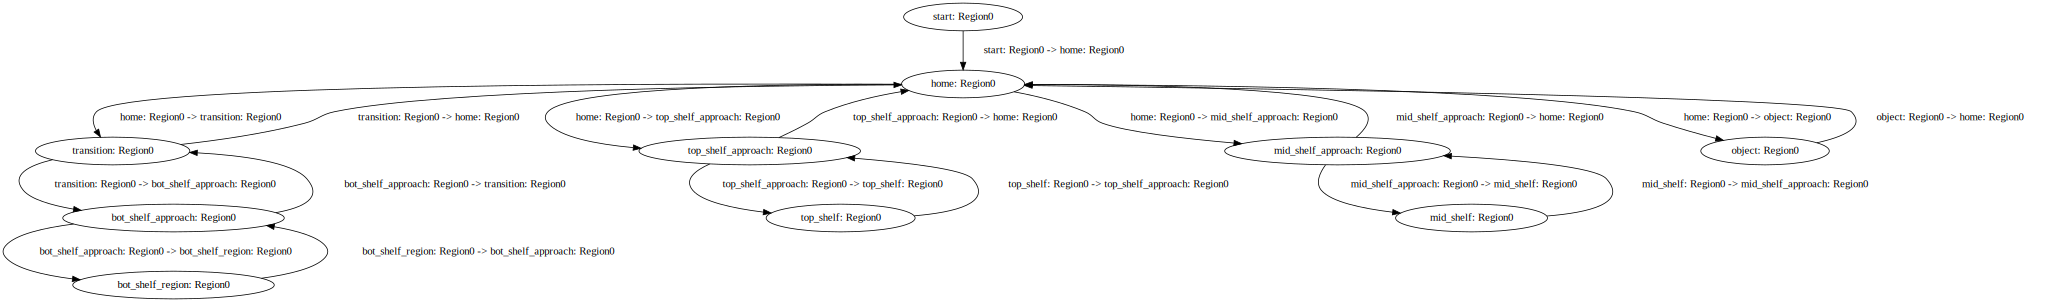

In [8]:
iris_regions_file = str(resources.files("anypick_dk") / "iris_regions" / "shelf_regions.yaml")
iris_regions = LoadIrisRegionsYamlFile(iris_regions_file)
gcs = create_base_gcs(iris_regions, sim_env)
show_gcs_graph(gcs)

# Plan a Path